### Aditya Jhaveri - N13689134 - aaj6301@nyu.edu - Lab 3

# Lab 3: Generating Text with an Autoregressive Model

In this lab, we will build a simple model for generating text in the style of a given book. In lecture, we learned about **probabalistic models**, which views the data given as the result of some random process. In this lab, we will be using this probablistic assumption to **generate new data**. Specifically, we will use an autoregressive model, as discussed in Lecture 4. Our model will begin with a list of words, and generate a new word based on the $k$ most recent previous words. $k$ is chosen to be a small fixed constant, which limits the complexity of the model.

Sometimes this type of model is also called a Markov Model. Similar techniques can be used for time-series and really any other data that has some notion of _recency_. For example, our Lab 2 studied an auto-regressive model for time series data. Even fancy modern language models like the GPT family of models are auto-regressive.

We get our input data from [Project Gutenberg](https://www.gutenberg.org/), a free library of public-works books made available online. By default, we include four books in this lab:
- _Alice in Wonderland_ by Lewis Carroll
- _Metamorphosis_ by Franz Kafka
- _The Count of Monte Cristo_ by Alexandre Dumas
- _The Complete Works of William Shakespeare_ by William Shakespeare

You will be able to add or change these book as you please, and there is code to make this relatively seamless. Pick your favorite work on the site!

---

The goals of this lab are to:
- Get some experience preprocessing data
- Train and generate text with an autoregressive model
- Understand the quality/plagiarism tradeoff that comes with increasing the complexity of the autoregressive model
- Get some experience building experiments that teach us about our models


In [453]:
# Importing Libararies

import random
import numpy as np
from tqdm import tqdm # Quality-of-life package, makes loading bars in for loops. See github.com/tqdm/tqdm for details.

import matplotlib.pyplot as plt
plt.style.use('classic') # Optional styling for the plots. I think it's pretty.

---

# 1. Preprocessing text

First, we have some code to help you download books from Project Gutenberg directly. The function `download_from_book_id(bookid, bookname)` will take the id of a book on Gutenberg and download it locally as the file `bookname.txt`.

However, we will see that the `.txt` files hosted by Project Gutenberg have headers and footer containing some metadata and legal text. Your first coding task will be to remove that metadata and legal text.

To use your own book of interest, search for it on Project Gutenberg, and take the number at the end of the url for that page. For instance, if you search for _The Count of Monte Cristo_, you will get the url `https://www.gutenberg.org/ebooks/1184`, and so the `bookid=1184` for that book.


In [454]:
#Code adapted from https://pypi.org/project/Gutenberg/ to help download from
#Project Gutenberg (www.gutenberg.org/) automatically. You don't need to read this.

def _format_download_urls(etextno):
    """
    Returns the possible urls location on the Project Gutenberg servers for a
    given text. Mostly ripped from https://pypi.org/project/Gutenberg/.
    """
    uri_root = r'http://www.gutenberg.lib.md.us'

    if 0 < etextno < 10:
        oldstyle_files = (
            'when11',
            'bill11',
            'jfk11',
            'getty11',
            'const11',
            'liber11',
            'mayfl11',
            'linc211',
            'linc111',
        )
        etextno = int(etextno)
        return '{root}/etext90/{name}.txt'.format(
            root=uri_root,
            name=oldstyle_files[etextno - 1])

    else:
        etextno = str(etextno)
        extensions = ('.txt', '-8.txt', '-0.txt')
        urls = []
        for extension in extensions:
            uri = '{root}/{path}/{etextno}/{etextno}{extension}'.format(
                root=uri_root,
                path='/'.join(etextno[:len(etextno) - 1]),
                etextno=etextno,
                extension=extension)
            urls.append(uri)
        return urls

In [455]:
def download_from_book_id(bookid, bookname):
  """
  Downloads a from book from Project Gutenberg given the book's id number, and
  stores it locally in `bookname.txt`.

  :param      bookid:    The id of the book on Project Gutenberg
  :type       bookid:    int
  :param      bookname:  The name to give the book (or rather the file path to the book)
  :type       bookname:  str
  """

  book_dst = f'{bookname}.txt'

  import os
  from six.moves import urllib

  if os.path.isfile(book_dst):
      print('File %s is already downloaded' % book_dst)
  else:
      possible_urls = _format_download_urls(bookid)
      print(possible_urls)
      for url in possible_urls:
        print(f'trying {url}...')
        try:
          urllib.request.urlretrieve(url, book_dst)
          print(f'Downloaded {bookname}.txt, with book id {bookid}.')
          return
        except urllib.error.HTTPError:
          None
      raise NameError("Couldn't find that book on Gutenberg")


In [456]:
download_from_book_id(100, "Shakespeare")
download_from_book_id(5200, "Metamorphosis")
download_from_book_id(11, "Wonderland")
download_from_book_id(1184, "MonteCristo")

File Shakespeare.txt is already downloaded
File Metamorphosis.txt is already downloaded
File Wonderland.txt is already downloaded
File MonteCristo.txt is already downloaded


---

Now we have stored `Shakespeare.txt`, `Metamorphosis.txt`, `Wonderland.txt`, and `MonteCristo.txt` locally. Let's open up one of these files and look at the first 1000 characters:

---

In [457]:
wonderland_book_text = ""

for line in open("Wonderland.txt"):
    if "***" in line.strip():
        continue
    wonderland_book_text = wonderland_book_text + " " + line.strip()

wonderland_book_text = " ".join(wonderland_book_text.split())
print(wonderland_book_text[0:1000])

[Illustration] Alice’s Adventures in Wonderland by Lewis Carroll THE MILLENNIUM FULCRUM EDITION 3.0 Contents CHAPTER I. Down the Rabbit-Hole CHAPTER II. The Pool of Tears CHAPTER III. A Caucus-Race and a Long Tale CHAPTER IV. The Rabbit Sends in a Little Bill CHAPTER V. Advice from a Caterpillar CHAPTER VI. Pig and Pepper CHAPTER VII. A Mad Tea-Party CHAPTER VIII. The Queen’s Croquet-Ground CHAPTER IX. The Mock Turtle’s Story CHAPTER X. The Lobster Quadrille CHAPTER XI. Who Stole the Tarts? CHAPTER XII. Alice’s Evidence CHAPTER I. Down the Rabbit-Hole Alice was beginning to get very tired of sitting by her sister on the bank, and of having nothing to do: once or twice she had peeped into the book her sister was reading, but it had no pictures or conversations in it, “and what is the use of a book,” thought Alice “without pictures or conversations?” So she was considering in her own mind (as well as she could, for the hot day made her feel very sleepy and stupid), whether the pleasure o

---

We can see that most of this is legal exta and metadata we do not want to include in our machine learning model. Conveniantly, Project Gutenberg added the following line of text to each book at the start:
> `*** START OF THE PROJECT GUTENBERG EBOOK`

Similarly, the end of the book has a huge amount of text (about 20,000 characters) that is not actually part of the book. Again, Project Gutenberg has the following line of text to note where the actual book ends:
> `*** END OF THE PROJECT GUTENBERG EBOOK`

Your first task is to write the following function `word_sequence_from_file`. This function is given a filepath to a locally downloaded Project Gutenberg book. It reads that file, finds where the text of the book actually starts and ends (i.e. without metadata and legal text), and returns the text of the book as a list of strings.

You should use the command `str.split()` to turn a string into a list of words. An example is given below.

In [458]:
# An example of string splitting
str = "This is a string.\n\n\nIt has a new line     and \t lots of whitespace in it. Some punctuation too -- like this!!!"
print(str.split())
str = str.replace(".", "")
print(str.split())

['This', 'is', 'a', 'string.', 'It', 'has', 'a', 'new', 'line', 'and', 'lots', 'of', 'whitespace', 'in', 'it.', 'Some', 'punctuation', 'too', '--', 'like', 'this!!!']
['This', 'is', 'a', 'string', 'It', 'has', 'a', 'new', 'line', 'and', 'lots', 'of', 'whitespace', 'in', 'it', 'Some', 'punctuation', 'too', '--', 'like', 'this!!!']


In [459]:
def word_sequence_from_file(filepath):
    """
    Given a filepath to a text file for a Project Gutenberg book, this splits
    the book into a list of strings, where each string is a word from the book.
    Foratting data, like where \n or spaces happen is destroyed by this, but
    punctuation like "word." are preserved.

    :param      filepath:  The filepath to the book
    :type       filepath:  string

    :returns:   A list of strings without any whitespace.
    :rtype:     List of string
    """

    word_sequence = ""

    print(filepath)

    for line in open(filepath):
        if "***" in line.strip():
            continue
        word_sequence = word_sequence + " " + line.strip()

    word_sequence = word_sequence.split()

    return word_sequence

In [460]:
shakespeare = word_sequence_from_file("Shakespeare.txt")
metamorphosis = word_sequence_from_file("Metamorphosis.txt")
wonderland = word_sequence_from_file("Wonderland.txt")
montecristo = word_sequence_from_file("MonteCristo.txt")

Shakespeare.txt
Metamorphosis.txt
Wonderland.txt
MonteCristo.txt


To verify that the text looks correct, we can use `" ".join(word_sequence)` to turn a list of strings back into text. Note that we have replaced all whitespace with just a space, so the formatting looks a bit different. The words should be the same though.

In [461]:
# Prints the first 100 words from Kafka's Metamorphosis
# It's okay if there's a couple extra words at the beginning like
# > "by Franz Kafka Translated by David Wyllie"
# This is just a couple words that will not change our model significantly

display(" ".join(metamorphosis[1:100]))

'Project Gutenberg eBook of Metamorphosis, by Franz Kafka This eBook is for the use of anyone anywhere in the United States and most other parts of the world at no cost and with almost no restrictions whatsoever. You may copy it, give it away or re-use it under the terms of the Project Gutenberg License included with this eBook or online at www.gutenberg.org. If you are not located in the United States, you will have to check the laws of the country where you are located before using this eBook. ** This is a COPYRIGHTED Project Gutenberg eBook, Details'

---

#2. Learning an Autoregressive Model

We will explore a probabilistic model of the English language. We will describe this as a generative model; that is, we describe how book is randomly generated.



We can approximate the structure of a book using a simple model called a **Markov Model** or autoregressive model. A markov model of **order** 0 predicts that each word in the book occurs with a fixed probability, independent of all other words. We can fit such a model to the book by counting the number of occurances of each word in that text, and using these counts as probabilities. For example, we could generate the following sentence from Kafka's _Metamorphosis_:

> and calmness her he way “Gregor! to thought, dark bone fact, in they it than she way as bringing

This obviously misses basic grammar because the model chooses each word independently.
This does not capture how language works, since in reality there are huge correlations between consequtive words. For example, in English, adjectives typically come before nouns -- we say "a red boat" not "a boat red".

We get a more complex model by allowing the probability of choosing each successive word to depend on the preceding words. A **Markov Model of order $k$** predicts that each word occurs with some probability, but that probability depends on the previous $k$ consequtive words, called a **k-gram**.

> For example, suppose a book has the string `My name is` appear 10 times in it. 4 of those times are followed by `Alice`, 2 of those are followed by `Bob`, 2 by `Jesse`, and 2 by `Steve`. Then, a Markov Model of order 3 predicts that the word following the 3-gram `My name is` will be `Alice` with probability $\frac{4}{10}$, `Bob` with probability $\frac{2}{10}$, `Jesse` with probability $\frac{2}{10}$, and `Steve` with probability $\frac{2}{10}$.


---
_This text introduction to Markov Models is a paraphrasing of the [this](https://www.cs.princeton.edu/courses/archive/spr05/cos126/assignments/markov.html) assignment taught at Princeton, originally taught by Bob Sedgewick and Kevin Wayne._

---

Your next task is to write the following function, which, for each k-gram in a book, counts the frequency with which each word appears after that k-gram.

In [462]:
def make_freq_dict(k, word_sequence):
    """
    Makes a "frequency dictionary" called `freq_dict` from a sequence of words.
    For each k-gram that appears in `word_sequence`, freq_dict[k_gram] is
    another dictionary that maps words to how often they occur after k_gram.

    For example, if k=3, suppose that running `freq_dict["they did something"]`
    returns following dictionary:
        {
            "weird": 4,
            "funny": 3,
            "strange.": 7
        }
    Then, the `word_sequence` has the phrase "they did something weird" appear
    4 times, "they did something funny" appear 3 times, and "they did something
    strange." appear 7 times. In other words,
    `freq_dict["they did something"]["strange"]` returns how many times
    "they did something strange" appears in `word_sequence`.

    :param      k:              Size of k-gram
    :type       k:              int
    :param      word_sequence:  A book, broken up into a list of strings
    :type       word_sequence:  List of string

    :returns:   Frequency dictionary
    :rtype:     Dict that maps strings to {Dict that maps string to ints}
    """
    freq_dict = dict()
    if k == 0:
        for i in range(0, len(word_sequence)):
            if word_sequence[i] in freq_dict:
                value = freq_dict[word_sequence[i]]
                freq_dict.update({word_sequence[i]: value + 1})
            else:
                freq_dict[word_sequence[i]] = 1
    
    else:
        pre = []
        for i  in range(0, k):
            pre.append(word_sequence[i])
        for i in range(k, len(word_sequence)):
            if " ".join(pre) in freq_dict:
                count_dict = freq_dict[" ".join(pre)]
                if word_sequence[i] in count_dict:
                    value = count_dict[word_sequence[i]]
                    count_dict.update({word_sequence[i]: value + 1})
                    freq_dict.update({" ".join(pre): count_dict})
                else:
                    count_dict[word_sequence[i]] = 1
                    freq_dict.update({" ".join(pre): count_dict})
            else:
                count_dict = dict()
                freq_dict[" ".join(pre)] = {word_sequence[i]: 1}
            pre.pop(0)
            pre.append(word_sequence[i])

    return freq_dict

---

Next, write the following functions that use a `freq_dict` to predict the next words given a $k$-gram, and to generate a whole paragraph given a starting $k$-gram. Be sure to carefully read the descriptions of the functions.

In [463]:
def predict_next_word(this_kgram, freq_dict):
    """
    Randomly picks the next work given the previous k-gram, using the frequency
    of possible next works according to `freq_dict`. If `freq_dict` does not
    contain the k-gram, return None.

    :param      this_kgram:  The current k-gram
    :type       this_kgram:  string
    :param      freq_dict:   A frequency dictionary
    :type       freq_dict:   Dict that maps strings to {Dict that maps string to ints}

    :returns:   The next word, or None
    :rtype:     string or None
    """
    if this_kgram in freq_dict:
        d = freq_dict[this_kgram]
        keys, values = list(d.keys()), list(d.values())
        next_word = random.choices(keys, weights=values, k=1)
        return next_word[0]
        
    return None



def predict_paragraph(start_kgram, k, freq_dict, gen_length=300):
    """
    Given a starting k-gram, this randomly generates `gen_length` many new
    words to form a paragraph of text consistent with `freq_dict`. If the last
    word in the book is generated (i.e. if `predict_next_word` returns None),
    then this will short-circuit and stop generating words early.

    :param      start_kgram:  The kgram to start from.
    :type       start_kgram:  List of string
    :param      k:            k-gram size
    :type       k:            int
    :param      freq_dict:    A frequency dictionary
    :type       freq_dict:    Dict that maps strings to {Dict that maps string to ints}
    :param      gen_length:   The number of words to generate.
    :type       gen_length:   int

    :returns:   A generated paragraph
    :rtype:     List of string
    """

    if k == 0:
        gen_para = []
        for i in range(0, gen_length):
            keys, values = list(freq_dict.keys()), list(freq_dict.values())
            next_word_0 = random.choices(keys, weights=values, k=1)[0]
            gen_para.append(next_word_0)
        return gen_para
    gen_para = list(start_kgram)
    k_gram = start_kgram
    while(len(gen_para) < gen_length):
        next_word = predict_next_word(" ".join(k_gram), freq_dict)
        if next_word is None:
            return gen_para
        gen_para.append(next_word)
        k_gram.pop(0)
        k_gram.append(next_word)
    return gen_para

In [ ]:
# Test code

# Pick k and make a frequency dictionary from Metamorphosis.
k_test = 3
freq_dict_test = make_freq_dict(k_test, metamorphosis)

With these functions, we can run some sample code and see how well our synthetic text generator works! Mess around with the value of `k_test` below to see how changing the size of the $k$-gram impacts the quality of the generated  text. You can also swap out the book from _Metamorphosis_ to any other book you prefer. Lastly, you can change what the starting $k$-gram is by changing `start_test` to some other $k$-gram that appears in your book.

- When you are done, leave this at `k_test=3` and move onto the next section.



In [465]:
# Pick k and make a frequency dictionary from Metamorphosis.
k_test = 3
freq_dict_test = make_freq_dict(k_test, metamorphosis)

# pick a random starting k-gram from the freq-dict.
start_test = random.choice(list(freq_dict_test.keys())).split()

# Alternatively, pick the start of the book as the first k-gram
# start_test = metamorphosis[0:k_test - 1]

# Generate a paragraph, and print it.
gen_paragraph = predict_paragraph(start_test, k_test, freq_dict_test)
print(" ".join(gen_paragraph))

danced around. For a moment everything remained quiet. “They’re not opening the door”, Gregor said to himself, and froze very still, although his little legs only became all the more deeply because of that. What should he do now? The next train went at seven; if he were being assailed from all sides. With his head and legs pulled in against him and his family they were all pressed against the door and listening. Gregor slowly pushed his way over to the door of the bedroom opened and Mr. Samsa appeared in his uniform with his wife on one arm and his daughter on the other. All of them had been crying a little; Grete now and then he stood up from the table and wrote three letters of excusal, Mr. Samsa to his employers, Mrs. Samsa to her contractor and Grete to her principal. The cleaner came in while they were talking, Mr. and Mrs. Samsa were struck, almost simultaneously, with the thought of how his finger had still hurt the day before yesterday. “Am I less sensitive than I used to be, t

---

#3. Creativive or Copying?

This has effectively generated a nice paragraph of text that really feels in the style of Kafka/Shakespeare/etc. It is writing whole sentences that usually feel like valid English. While it is not writing fully coherent paragraphs, it is nevertheless pretty effective. But we quickly run into a common issue with generative models: is this $k$-gram model creating new sentences, or is it just copying whole passages from the original text? For instance, all $k$-grams in our generated text must exist in the original book.

We approach this question with a very simple metric to check for plagiarism: the **Longest Common Substring** (LCS). Below, we use the `LcsFinder` class to do two things:
1. We compute the length of the longest common substring between the full book and our generated paragraph.
1. We visualize long common substrings using a simple approach: starting from the first word of the generated paragraph, we color all of the following words that appear in that same order in the original text in one color. We switch colors everytime the generated text deviates from the original text.

## 3.0 Code we give to you

This is the class `LcsFinder`. Construct it with `LcsFinder(word_sequence)`, where `word_sequence` is a long list of strings (i.e. a book). Once constructed, there's two functions you might want to use:
1. `LcsFinder.lcs_length(small_sequence)`, which finds the length of the Longest Common Substring (LCS) of `small_sequence` and `word_sequence`. `small_sequence` should also be a list of strings.
2. `LcsFinder.greedy_lcs_markdown(small_sequence)`, which takes `small_sequence` and uses Markdown to highlight substrings of that text, where each substring of `small_sequence` is also a substring of `word_sequence`. It uses a greedy strategy to heuristically make these substrings as long as possible.

You don't need to understand how the code in section 3.0 works, but you should understand how to use it. The first code block below is the actual code implimentation, and the two code blocks after that show how to run the code.

_You can expand the code blocks by clocking on <font color="blue">Show code</font>, and can hide the code again with the `Show/hide code` menu in the command pallate, which you can open with the key command `cmd-shift-p`._

In [466]:
#The code that impliments `LcsFinder`

from IPython.display import display, Markdown #

# Colors to use in the Markdown Text
md_colors = ["#009292", "#FF6DB6", "#490092", "#006DDB", "#B66DFF", "#920000", "#DB6D00"]

def list_of_seqs_to_markdown(list_of_sequences):
    """
    Takes in a list-of-list-of-strings, and colors each sublist with a single
    color cycling through the list `md_colors` to pick those colors

    :param      list_of_sequences:  List of list of words
    :type       list_of_sequences:  List of list of words
    """

    # The output string
    display_string = ""
    for i, word_sequence in enumerate(list_of_sequences):
        display_string = display_string + f'<font color={md_colors[i % len(md_colors)]}>{" ".join(word_sequence)}</font> '

    # Draw that string with Markdown
    display(Markdown(display_string))


class LcsFinder:
    """
    Internally, this class takes `word_sequence` and
    builds a hash table from any k-gram that appears in
    `word_sequence` to the list of all indices where that
    k-gram appears in `word_sequence`. This makes finding
    the LCS pretty fast.
    It also stores a set of all less-than-k grams that appear
    in the text, but just as a set and not as a hash table.
    """

    def __init__(self, word_sequence, k=3):
        """
        By default, this hash table uses 3-grams, this seems to work well. Feel
        free to pass in a different k-value, though keep in mind this is a
        heuristic speedup, and is unrelated to the k-gram from the language
        model.

        :param      word_sequence:  A book
        :type       word_sequence:  List of strings
        :param      k:              Heuristic k-gram size for efficient lookup
        :type       k:              int
        """
        self.k = k
        self.word_sequence = word_sequence
        self.index_hash = dict()
        self.short_gram_set = set()

        for i in range(len(word_sequence)-k):

            k_gram = " ".join(word_sequence[i:i+k])  # Build this k-gram
            if k_gram not in self.index_hash:
                self.index_hash[k_gram] = []  # Add it to the hash table if it ain't there
            self.index_hash[k_gram].append(i)  # And add the index to the list

            # Update the set of short grams with all possible grams starting at i, and with length < k.
            self.short_gram_set.update({" ".join(word_sequence[i:i+j]) for j in range(1,k)})

    def length_of_lcs_from_start(self, small_sequence, start_idx):
        """
        Look for the longest common substring of word_sequence and
        small_sequence, subject to the substring starting at
        `small_sequence[start_idx]`. Returns the length of this LCS, measured in
        words.

        :param      small_sequence:  A small word sequence
        :type       small_sequence:  List of strings
        :param      start_idx:       The index where the LCS has to start at
        :type       start_idx:       int

        :returns:   Length of the LCS, measure in words
        :rtype:     int
        """

        # Build the k-gram rooted at start_idx
        start_k_gram = " ".join(small_sequence[start_idx:start_idx+self.k])

        # If the k-gram is in the big hash table,
        if start_k_gram in self.index_hash:

            longest = 0

            # Scan over all indices in the list in the hash table
            for word_seq_index in self.index_hash[start_k_gram]:

                # While loop, starting at size k, expanding the length of the LCS until the sequences stop matching
                i = self.k
                while (word_seq_index + i < len(self.word_sequence) and # in-bounds on word_sequence
                       start_idx + i < len(small_sequence) and # in-bounds on small_sequence
                       self.word_sequence[word_seq_index + i] == small_sequence[start_idx + i]): # the words are the same
                    i = i+1

                # The length of the longest LCS seen so far is kept
                longest = max(longest, i)
            return longest
        else:
            # If the k-gram ain't in the big hash table, check if it's sub-grams are in the stored set
            for i in range(self.k-1,0,-1): # In order from k-1 to 1
                if " ".join(small_sequence[start_idx:start_idx+i]) in self.short_gram_set:
                    return i
            return 0

    def lcs_length(self, small_sequence):
        """
        Given `small_sequence`, a list of strings, this returns the length of
        the longest common substring between `small_sequence` and
        `word_sequence`

        :param      small_sequence:  A small sequence of words
        :type       small_sequence:  List of strings

        :returns:   Length of the LCS, measured in words
        :rtype:     int
        """
        longest = 0

        # Just iterative over all starting words in `small_sequence` and keep the biggest number
        for i in range(len(small_sequence)):
            sequence_len = self.length_of_lcs_from_start(small_sequence, i)
            longest = max(longest, sequence_len)

        return longest

    # Given `small_sequence`, a list of strings, this prints highlighted markdown that shows where one substring of `word_sequence` ends and the next one starts. If a word doesn't appear in `word_sequence`, we just treat it like a substring of length 1.

    def greedy_lcs_markdown(self, small_sequence):
        """
        Given `small_sequence`, a list of strings, this prints highlighted
        markdown that shows where one substring of `word_sequence` ends and the
        next one starts. If a word doesn't appear in `word_sequence`, we just
        treat it like a substring of length 1.

        :param      small_sequence:  A small sequence of words
        :type       small_sequence:  List of strings

        :returns:   Markdown display text (renders by default on Jupyter)
        :rtype:     Markdown display text
        """
        list_of_sequences = []  # The output list

        i = 0
        while i < len(small_sequence):
            # iteratate over small_sequence, finding the lcs rooted at index i,
            # and color that LCS accordingly.
            sequence_len = max(self.length_of_lcs_from_start(small_sequence, i), 1)
            list_of_sequences.append(small_sequence[i:i+sequence_len])
            i = i + sequence_len

        return list_of_seqs_to_markdown(list_of_sequences)


In [467]:
#@markdown An example of how to build an `LcsFinder`. The `str.split()` function turns the string into a list of string.
test_word_sequence = "wow this is a sentence that I wrote like wow this is a real thing".split(" ")
test_small_sequence = "heck this is a sentence that is sgetti".split(" ")

test_LCS_finder = LcsFinder(test_word_sequence)
test_lcs_length = test_LCS_finder.lcs_length(test_small_sequence)
display(Markdown(f'The length of the LCS between `test_word_sequence` and `test_small_sequence` is {test_lcs_length}.'))

The length of the LCS between `test_word_sequence` and `test_small_sequence` is 5.

In [468]:
#@markdown An example of coloring the `small_sequence` by all the LCS's found in the word_sequence.
test_LCS_finder.greedy_lcs_markdown(test_small_sequence)

<font color=#009292>heck</font> <font color=#FF6DB6>this is a sentence that</font> <font color=#490092>is</font> <font color=#006DDB>sgetti</font> 

## 3.1 LCS on Generated Text

In [469]:
# Build an LcsFinder for Metamorphosis
metamorphosis_finder = LcsFinder(metamorphosis)

# Use the LcsFinder to find the LCS length in the generated paragraph
print(f'LCS length: {metamorphosis_finder.lcs_length(gen_paragraph)} words')

# Use the LcsFinder to highlight substrings in the generated text that appear in the original text.
metamorphosis_finder.greedy_lcs_markdown(gen_paragraph)

LCS length: 43 words


<font color=#009292>danced around. For a moment everything remained quiet. “They’re not opening the door”, Gregor said to himself,</font> <font color=#FF6DB6>and froze very still, although his little legs only became all the more</font> <font color=#490092>deeply because of that. What should he do now? The next train went at seven; if he were</font> <font color=#006DDB>being assailed from all sides. With his head and legs pulled in against him and his</font> <font color=#B66DFF>family they were all</font> <font color=#920000>pressed against the door and listening. Gregor slowly pushed his way over to the door</font> <font color=#DB6D00>of the bedroom opened and Mr. Samsa appeared in his uniform with his wife on one arm and his daughter on the other. All of them had been crying a little; Grete now and then</font> <font color=#009292>he stood up from the table and</font> <font color=#FF6DB6>wrote three letters of excusal, Mr. Samsa to his employers, Mrs. Samsa to her contractor and Grete to her principal. The cleaner came in while they were</font> <font color=#490092>talking, Mr. and Mrs. Samsa were struck, almost simultaneously, with the thought of how</font> <font color=#006DDB>his finger had still hurt the day before yesterday. “Am I less sensitive than I used to be, then?”, he thought, and was already sucking greedily at the cheese which had immediately, almost compellingly, attracted him much more than the</font> <font color=#B66DFF>object and the hand that held it. The woman most likely meant to fetch the things back out again when she had</font> <font color=#920000>become used to the</font> <font color=#DB6D00>situation—that Gregor would sometimes catch a friendly comment, or at least</font> <font color=#009292>not with the same</font> <font color=#FF6DB6>demands as before? There was no need to worry about things like that yet. Gregor was still there and had not</font> <font color=#490092>even touched at all as if it</font> <font color=#006DDB>had just been thrown down by chance. Gregor also refrained, this time, from spying out from under the</font> <font color=#B66DFF>couch and put more folds into it</font> 

---
Note that in the paragraph above, every chunk of text in the same color was copied directly from the original book.
This shows a non-trivial amount of copying going on. Despite only using $3$-grams, we are often copying much more than 3 words at a time from the original book. Sometimes, we are copying whole sentences.

We find ourselves at an impass:
- If we make $k$ too small, then we lose the structure of grammer, and generate nonsense.
- If we make $k$ too large, then we start plagiarizing.

Let's try to understand the scale of this problem. Take a book, generate 100 paragraphs of 300 words for each of 5 different values of $k$, and compute the length of the LCS between the book and the generated paragraph. Specifically, compute the $25^{th}$ quartile, median, and $75^{th}$ quartile of the LCS length across the 100 trials.

In [497]:
# Which values of k to generate k-grams for and estimate LCS lengths with
ks_to_plot = [1, 2, 3, 4, 5]

def gen_lcs_statistics(word_sequence):
    """
    Given a word_sequence, this generates 100 paragraphs of length 300
    at each of various choices of k-gram size (see `ks_to_plot`). It then
    returns the median, 25th quartile, and 75th quartile of the LCS's length
    at each value of k.

    More precisely, it should return a dictionary with the following shape:
        {
            "medians": np.array([numbers...]),
            "top_quartiles": np.array([numbers...]),
            "bot_quartiles.": np.array([numbers...])
        }
    Where top_quartiles is for the 75^th quartile, and bot_quartiles is for the 25^th quartile.

    :param      word_sequence:  The book
    :type       word_sequence:  List of string

    :returns:   A dictionary with keys "medians", "top_quartiles",
                "bot_quartiles", and values which are numpy vectors
                with the same length as `ks_to_plot`.
    :rtype:     Dict that maps string to numpy array
    """

    n_trials = 100  # number of trials
    gen_length_test = 300  # number of words to generate
    lcs_length_medians = []
    lcs_length_tops = []
    lcs_length_bots = []

    lcs_lengths = np.zeros((len(ks_to_plot), n_trials))
    for k in ks_to_plot:
        lcs_finder = LcsFinder(word_sequence, k=k)
        freq_dict_test = make_freq_dict(k, word_sequence)
        for i in range(0, n_trials):
            start_test = random.choice(list(freq_dict_test.keys())).split()
            gen_paragraph = predict_paragraph(start_test, k, freq_dict_test, gen_length=gen_length_test)
            lcs_lengths[k - 1, i] = lcs_finder.lcs_length(gen_paragraph)
        lcs_length_medians.append(np.median(lcs_lengths[k - 1, :]))
        lcs_length_tops.append(np.quantile(a=lcs_lengths[k - 1, :], q=0.75))
        lcs_length_bots.append(np.quantile(a=lcs_lengths[k - 1, :], q=0.25))

    return {"medians": np.array(lcs_length_medians), "top_quartiles": np.array(lcs_length_tops), "bot_quartiles": np.array(lcs_length_bots)}

In [471]:
# For a pretty long text, like shakespeare, this still should not take more than 45 seconds.

gen_lcs_statistics(shakespeare)

{'medians': array([  4.,  13.,  49., 164., 300.]),
 'top_quartiles': array([  5.  ,  16.  ,  64.25, 199.75, 300.  ]),
 'bot_quartiles': array([  4.  ,  12.  ,  39.  , 112.25, 227.5 ])}

---
Having generated this data, let's plot how the LCS length depends on $k$.
Write the below function, which should produce an image that looks roughly like the following image:

<img src="https://drive.google.com/uc?id=1J9VlSFelSAwa2r7-jrPLUGKf5mTanFyn"></img>

Slight deviations in the colors, shapes, labels, and other aesthetics are fine, but the same information should be portrayed -- a clear median line with clear $25^{th}$ and $75^{th}$ quartiles. The title should also state what book is being used, and the axes should be labeled.

<!-- the img tag is taken from this gdrive link: https://drive.google.com/file/d/1J9VlSFelSAwa2r7-jrPLUGKf5mTanFyn/view?usp=share_link -->


In [496]:
def plot_lcs_statistics(word_sequence, book_title, lcs_stats):
    """
    Given a book, it's title, and the LCS statistics generated by
    `gen_lcs_statistics`, this renders a plot to visualize the statistics.

    :param      word_sequence:  The book
    :type       word_sequence:  List of string
    :param      book_title:     The book's title
    :type       book_title:     String
    :param      lcs_stats:      The lcs statistics
    :type       lcs_stats:      Dict that maps string to numpy array
    """

    ## TODO: WRITE THIS CODE
    ## Use plot() to render the median as one line
    ## Use fill_between() to shade the area 25th and 75th quartiles with a low alpha value, like alpha=0.35
    # Get the number of words in the book
    num_words = 300

    # Extract median, 25th, and 75th percentiles from the lcs_stats
    median = lcs_stats['medians']
    percentile_25th = lcs_stats['top_quartiles']
    percentile_75th = lcs_stats['bot_quartiles']

    # X-axis values representing word indices
    # y_values = np.arange(num_words)
    # x_values = np.linspace(0, 5, num_words)
    # x_values = np.arange(ks_to_plot)
   
    

    # Plot the median
    plt.plot(ks_to_plot, median, label='Median', color='blue')

    # Shade the area between the 25th and 75th percentiles
    plt.fill_between(ks_to_plot, percentile_25th, percentile_75th, color='blue', alpha=0.35, label='25th-75th Percentile Range')

    # Add labels and title
    plt.xlabel('k')
    plt.ylabel('LCS Length in Words')
    plt.title(f'LCS Statistics for {book_title}: K vs Length of LCS')

    # Show the legend
    plt.legend()

    # Display the plot
    plt.show()


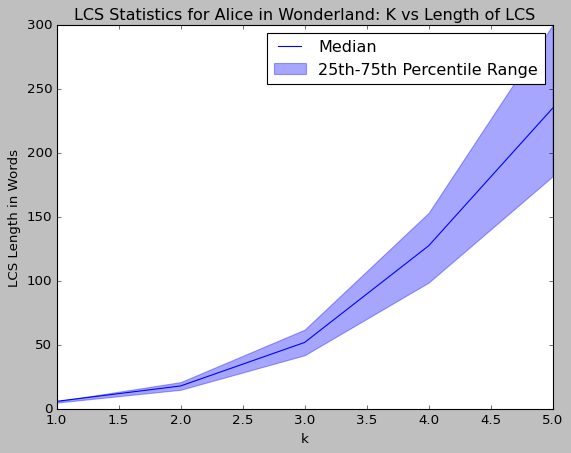

In [473]:
plot_lcs_statistics(wonderland, "Alice in Wonderland", gen_lcs_statistics(wonderland))

Okay, wow. That grows really fast. Exponentially even$\phantom{}^{\dagger}$. This means that, at least for the relatively small amount of training data we used, we get a poor tradeoff between quality (large $k$) and creativity (small $k$).

Maybe we were just unlucky with our choice of book?
Write the next function, which plots LCS lengths for many books all at once.
It should produce and output roughly like the following:

<img src="https://drive.google.com/uc?id=1JJrx3K5I_9qdE8ozTEr2lfyD1eLVu4oU"></img>

Again, slight deviations aesthetics are fine, but the same information should be portrayed.

<!-- the img tag is taken from this gdrive link: https://drive.google.com/file/d/1JJrx3K5I_9qdE8ozTEr2lfyD1eLVu4oU/view?usp=share_link -->


---

$\phantom{}^{[\dagger]}$_It's literally exponential. If you're curious, add `plt.yscale("log")` to your plotting code to see this curve become close-to-linear, suggesting this literally grows at the rate $LCS \approx e^{\Theta(k)}$._

In [498]:
shakes_stats = gen_lcs_statistics(shakespeare)
metamorphosis_stats = gen_lcs_statistics(metamorphosis)
wonderland_stats = gen_lcs_statistics(wonderland)
monte_cristo_stats = gen_lcs_statistics(montecristo)

In [475]:
plot_colors = ["#009292", "#FF6DB6", "#490092", "#006DDB", "#B66DFF", "#6DB6FF", "#B6DBFF", "#920000", "#924900", "#DB6D00", "#24FF24", "#FFFF6D"]

def plot_many_lcs_statistics(list_of_dicts):
    """
    Given a list of dicts, each with a book title, and the LCS statistics
    generated by `gen_lcs_statistics`, this renders a plot to visualize the statistics.

    The given dicts have the following shape, with these exact keys:
        {
            "book_name": string,
            "stats": output of plot_lcs_statistics()
        }

    :param      list_of_dicts:  A list of dicts
    :type       list_of_dicts:  List of dict
    """
    fig, ax = plt.subplots(nrows=len(list_of_dicts), ncols=1, figsize=(20, 20))
    ax = ax.flatten()
    
    ## The same basic idea as the last plot, but with many series overlaid. Make alpha=0.15 for the fill to keep the image legible.
    ## Use some subset of the list of colors at the top -- they are a visually nice set of colorblind-safe colors.
    i = 0
    for dict in list_of_dicts:
        book_name = dict["book_name"]
        stat = dict["stats"]
        print(book_name, stat)
        median = stat['medians']
        percentile_25th = stat['top_quartiles']
        percentile_75th = stat['bot_quartiles']
        plt.subplot(len(list_of_dicts), 1, i+1)
        plt.plot(ks_to_plot, median, label=f'{book_name} - Median', color=plot_colors[i%len(plot_colors)])
        plt.fill_between(ks_to_plot, percentile_25th, percentile_75th, color=plot_colors[i%len(plot_colors)], alpha=0.35, label='25th-75th Percentile Range')
        plt.xlabel('k')
        plt.ylabel('LCS Length in Words')
        plt.title(f'LCS Statistics for {book_name}: K vs Length of LCS')

        # Show the legend
        plt.legend(loc='upper left')
        i = i+1
    fig.tight_layout()
    plt.show()


In [492]:
def plot_lcs_statistics_one_frame(d):
    i = 0
    for x in d:
        book_name = x["book_name"]
        stats = x["stats"]
        median = stats['medians']
        percentile_25th = stats['top_quartiles']
        percentile_75th = stats['bot_quartiles']

        plt.plot(ks_to_plot, median, label=f"Median - {book_name}", color=plot_colors[i%len(plot_colors)])
        plt.fill_between(ks_to_plot, percentile_25th, percentile_75th, color=plot_colors[i%len(plot_colors)], alpha=0.15, label=f'25th-75th Percentile Range - {book_name}')
        plt.xlabel('k')
        plt.ylabel("LCS Length in words")
        
        i = i + 1
    plt.legend(loc=2, prop={'size': 9})
    plt.figure(figsize=(100, 100))
    plt.show()

All of Shakespeare {'medians': array([  4. ,  13. ,  49. , 146.5, 295. ]), 'top_quartiles': array([  5.,  15.,  60., 214., 300.]), 'bot_quartiles': array([  4.  ,  12.  ,  38.  , 111.75, 187.75])}
Metamorphosis {'medians': array([  6. ,  17. ,  56. , 147.5, 254.5]), 'top_quartiles': array([  7.,  20.,  70., 188., 300.]), 'bot_quartiles': array([  5.,  15.,  44., 111., 188.])}
Alice in Wonderland {'medians': array([  6. ,  17. ,  52. , 121.5, 239.5]), 'top_quartiles': array([  6.  ,  20.  ,  62.25, 163.25, 300.  ]), 'bot_quartiles': array([  5. ,  15. ,  42. ,  95.5, 181.5])}
Monte Cristo {'medians': array([  5. ,  11. ,  34. ,  97.5, 204.5]), 'top_quartiles': array([  5.,  13.,  40., 117., 285.]), 'bot_quartiles': array([  4.  ,  10.  ,  29.  ,  73.  , 161.25])}


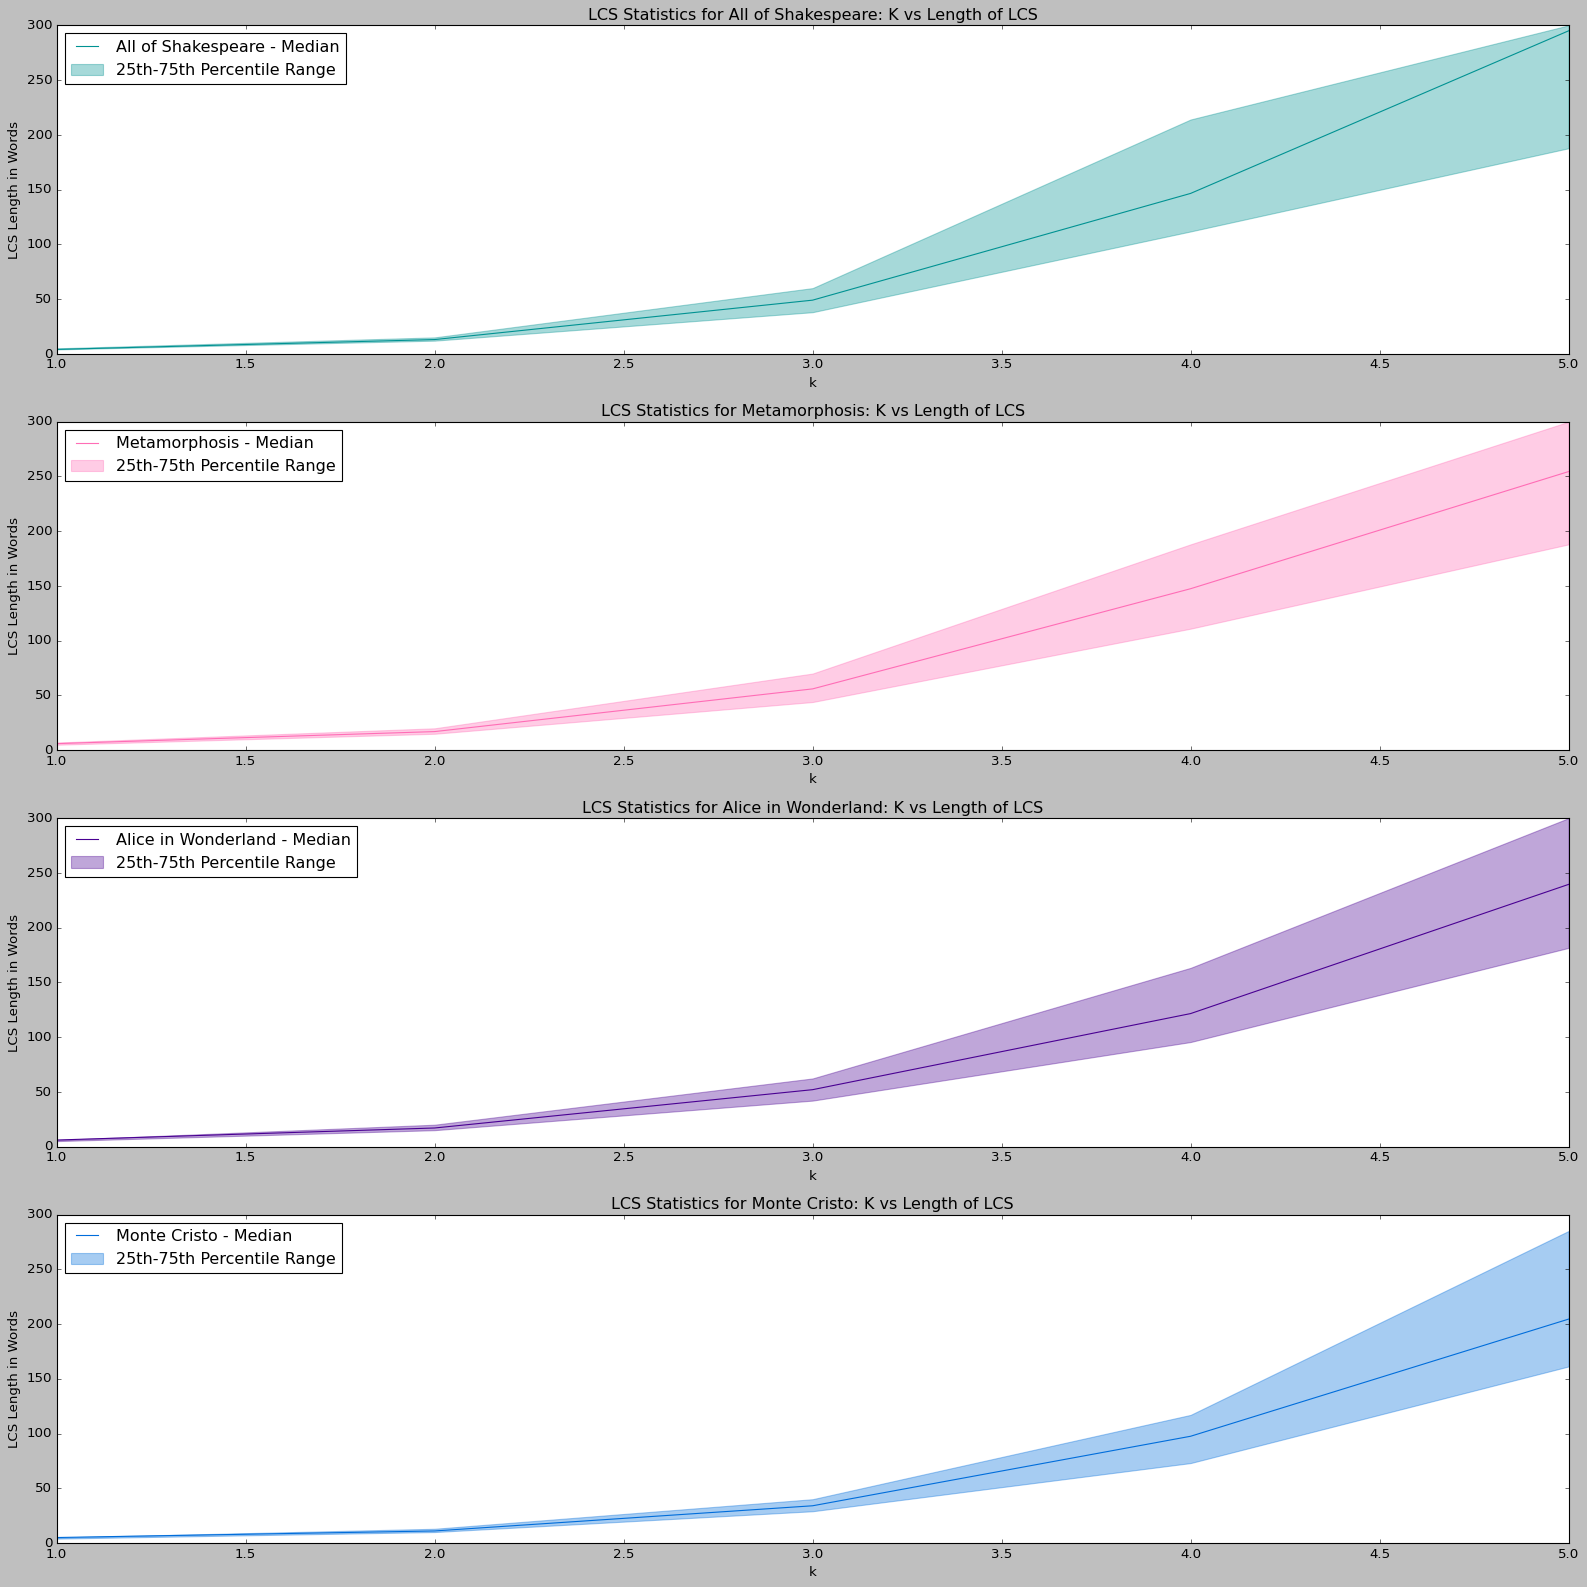

In [499]:
plot_many_lcs_statistics(
    [
        {
            "book_name": "All of Shakespeare",
            "stats": shakes_stats
        }, {
            "book_name": "Metamorphosis",
            "stats": metamorphosis_stats
        }, {
            "book_name": "Alice in Wonderland",
            "stats": wonderland_stats
        }, {
            "book_name": "Monte Cristo",
            "stats": monte_cristo_stats
        }
    ]
)

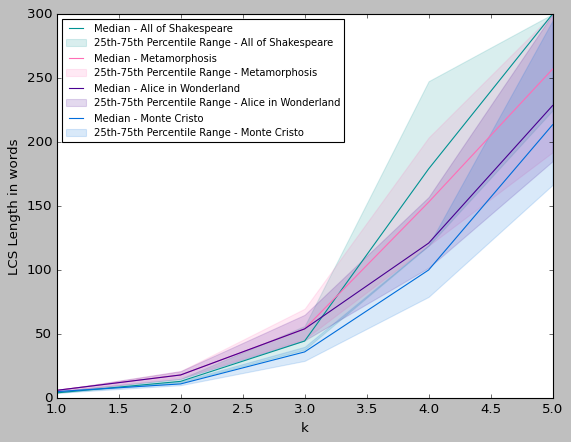

<Figure size 8000x8000 with 0 Axes>

In [493]:
plot_lcs_statistics_one_frame(
    [
        {
            "book_name": "All of Shakespeare",
            "stats": shakes_stats
        }, {
            "book_name": "Metamorphosis",
            "stats": metamorphosis_stats
        }, {
            "book_name": "Alice in Wonderland",
            "stats": wonderland_stats
        }, {
            "book_name": "Monte Cristo",
            "stats": monte_cristo_stats
        }
    ]
)

---

So while some books are a bit better than others, they still all seem to grow at an exponential rate. Improving upon this will with require a better model (we will discuss some later in the course), a lot more training data, or idealy both.

---

# 4.  (Bonus Question -- 2 / 20 points) Can you improve our model?

Code up a modification of our simple $k$-gram model that produces decent text (e.g. better than the 2-gram model) but copies less. To get bonus credit, post a screenshot of your generated text on Ed, using any Project Gutenberg book as the input data. Highlight the text with `LcsFinder` to highlight long common substrings. In your post, add a brief description of how you modified the model.

Think creatively! You are also free to look online for different modifications and technique other people have use, but your lab report should (informally) cite whatever sources you used.


In [479]:
# Write any code used for answering the bonus questions here

k = 5
book = word_sequence_from_file("Wonderland.txt")
print(book)

Wonderland.txt
['[Illustration]', 'Alice’s', 'Adventures', 'in', 'Wonderland', 'by', 'Lewis', 'Carroll', 'THE', 'MILLENNIUM', 'FULCRUM', 'EDITION', '3.0', 'Contents', 'CHAPTER', 'I.', 'Down', 'the', 'Rabbit-Hole', 'CHAPTER', 'II.', 'The', 'Pool', 'of', 'Tears', 'CHAPTER', 'III.', 'A', 'Caucus-Race', 'and', 'a', 'Long', 'Tale', 'CHAPTER', 'IV.', 'The', 'Rabbit', 'Sends', 'in', 'a', 'Little', 'Bill', 'CHAPTER', 'V.', 'Advice', 'from', 'a', 'Caterpillar', 'CHAPTER', 'VI.', 'Pig', 'and', 'Pepper', 'CHAPTER', 'VII.', 'A', 'Mad', 'Tea-Party', 'CHAPTER', 'VIII.', 'The', 'Queen’s', 'Croquet-Ground', 'CHAPTER', 'IX.', 'The', 'Mock', 'Turtle’s', 'Story', 'CHAPTER', 'X.', 'The', 'Lobster', 'Quadrille', 'CHAPTER', 'XI.', 'Who', 'Stole', 'the', 'Tarts?', 'CHAPTER', 'XII.', 'Alice’s', 'Evidence', 'CHAPTER', 'I.', 'Down', 'the', 'Rabbit-Hole', 'Alice', 'was', 'beginning', 'to', 'get', 'very', 'tired', 'of', 'sitting', 'by', 'her', 'sister', 'on', 'the', 'bank,', 'and', 'of', 'having', 'nothing', 'to'

In [480]:
# Referred to Medium.com articles Stackoverflow/Math.overflow forums

from collections import defaultdict

class NgramModel:
    def __init__(self, n):
        self.n = n
        self.ngram_freq = defaultdict(int)
        self.context_freq = defaultdict(int)

    def build_ngram_model(self, corpus):
        """
        Build the N-gram frequency dictionary from the given corpus.
        :param corpus: A list of words (e.g., ['the', 'cat', 'is', 'on', 'the', 'mat'])
        """
        for i in range(len(corpus) - self.n):
            ngram = tuple(corpus[i:i + self.n])
            context = ngram[:-1]  # Context is the first n-1 words
            self.ngram_freq[ngram] += 1
            self.context_freq[context] += 1

    def generate_text(self, seed_text, max_words=50, temperature=1.0):
        """
        Generate text based on the N-gram model, starting from seed text.
        :param seed_text: Initial list of words to start the generation.
        :param max_words: Maximum number of words to generate.
        :param temperature: Controls randomness; higher values make the model more random.
        :return: A string of generated text.
        """
        current_context = tuple(seed_text[-(self.n-1):])  # Start with the last n-1 words of the seed text
        generated_text = seed_text[:]
        
        for _ in range(max_words):
            next_word = self._get_next_word(current_context, temperature)
            if not next_word:
                break
            generated_text.append(next_word)
            current_context = tuple(generated_text[-(self.n-1):])  # Update context

        return ' '.join(generated_text)

    def _get_next_word(self, context, temperature):
        """
        Get the next word based on the current context.
        :param context: The last n-1 words.
        :param temperature: A scaling factor for randomness.
        :return: The next word.
        """
        # Get all possible N-grams that match the current context
        possible_ngrams = {ngram: count for ngram, count in self.ngram_freq.items() if ngram[:-1] == context}

        if not possible_ngrams:
            return None  # No valid N-grams found, so terminate

        # Convert counts to probabilities
        total_count = sum(possible_ngrams.values())
        word_probs = {ngram[-1]: count / total_count for ngram, count in possible_ngrams.items()}

        # Apply temperature scaling to probabilities
        word_probs = self._apply_temperature_scaling(word_probs, temperature)

        # Randomly choose the next word based on the scaled probabilities
        next_word = random.choices(list(word_probs.keys()), list(word_probs.values()))[0]
        return next_word

    def _apply_temperature_scaling(self, word_probs, temperature):
        """
        Apply temperature scaling to the word probabilities to add randomness.
        :param word_probs: Dictionary of words and their probabilities.
        :param temperature: The temperature to scale probabilities.
        :return: A dictionary with scaled probabilities.
        """
        scaled_probs = {}
        for word, prob in word_probs.items():
            scaled_probs[word] = prob ** (1.0 / temperature)

        # Normalize probabilities
        total_prob = sum(scaled_probs.values())
        for word in scaled_probs:
            scaled_probs[word] /= total_prob

        return scaled_probs

In [481]:
k = 3
print(book)

['[Illustration]', 'Alice’s', 'Adventures', 'in', 'Wonderland', 'by', 'Lewis', 'Carroll', 'THE', 'MILLENNIUM', 'FULCRUM', 'EDITION', '3.0', 'Contents', 'CHAPTER', 'I.', 'Down', 'the', 'Rabbit-Hole', 'CHAPTER', 'II.', 'The', 'Pool', 'of', 'Tears', 'CHAPTER', 'III.', 'A', 'Caucus-Race', 'and', 'a', 'Long', 'Tale', 'CHAPTER', 'IV.', 'The', 'Rabbit', 'Sends', 'in', 'a', 'Little', 'Bill', 'CHAPTER', 'V.', 'Advice', 'from', 'a', 'Caterpillar', 'CHAPTER', 'VI.', 'Pig', 'and', 'Pepper', 'CHAPTER', 'VII.', 'A', 'Mad', 'Tea-Party', 'CHAPTER', 'VIII.', 'The', 'Queen’s', 'Croquet-Ground', 'CHAPTER', 'IX.', 'The', 'Mock', 'Turtle’s', 'Story', 'CHAPTER', 'X.', 'The', 'Lobster', 'Quadrille', 'CHAPTER', 'XI.', 'Who', 'Stole', 'the', 'Tarts?', 'CHAPTER', 'XII.', 'Alice’s', 'Evidence', 'CHAPTER', 'I.', 'Down', 'the', 'Rabbit-Hole', 'Alice', 'was', 'beginning', 'to', 'get', 'very', 'tired', 'of', 'sitting', 'by', 'her', 'sister', 'on', 'the', 'bank,', 'and', 'of', 'having', 'nothing', 'to', 'do:', 'once'

In [482]:
model = NgramModel(k)
model.build_ngram_model(book)

In [483]:
seed_text = random.choices(list(model.ngram_freq.keys()), k=1)[0]
print(list(seed_text))

['court,', 'without', 'even']


In [484]:
generated_text = model.generate_text(seed_text=list(seed_text), max_words=300, temperature=1.2)
print(generated_text)

court, without even looking round. “I’ll fetch the executioner ran wildly up and rubbed its eyes: then it watched the White Rabbit, with a soldier on each side, and opened their eyes and mouths so _very_ wide, but she gained courage as she could not answer without a cat! It’s the most important piece of it at all; and I’m sure _I_ don’t want _you_ with us!’” “They were learning to draw, you know—” (pointing with his head!’” “How dreadfully savage!” exclaimed Alice. “That’s very curious!” she thought. “But everything’s curious today. I think I must be really offended. “We won’t talk about cats or dogs either, if you drink much from a bottle marked “poison,” so Alice ventured to ask. “Suppose we change the subject. “Go on with the Gryphon. “Of course,” the Mock Turtle said with some difficulty, as it can be,” said the Duck. “Found _it_,” the Mouse was bristling all over, and she grew no larger: still it was good practice to say it out to sea. So they had at the Queen, and Alice looked ro

In [485]:
print(book)
lcs_finder_bonus = LcsFinder(book, k=k)
print(lcs_finder_bonus.lcs_length(generated_text.split()))

['[Illustration]', 'Alice’s', 'Adventures', 'in', 'Wonderland', 'by', 'Lewis', 'Carroll', 'THE', 'MILLENNIUM', 'FULCRUM', 'EDITION', '3.0', 'Contents', 'CHAPTER', 'I.', 'Down', 'the', 'Rabbit-Hole', 'CHAPTER', 'II.', 'The', 'Pool', 'of', 'Tears', 'CHAPTER', 'III.', 'A', 'Caucus-Race', 'and', 'a', 'Long', 'Tale', 'CHAPTER', 'IV.', 'The', 'Rabbit', 'Sends', 'in', 'a', 'Little', 'Bill', 'CHAPTER', 'V.', 'Advice', 'from', 'a', 'Caterpillar', 'CHAPTER', 'VI.', 'Pig', 'and', 'Pepper', 'CHAPTER', 'VII.', 'A', 'Mad', 'Tea-Party', 'CHAPTER', 'VIII.', 'The', 'Queen’s', 'Croquet-Ground', 'CHAPTER', 'IX.', 'The', 'Mock', 'Turtle’s', 'Story', 'CHAPTER', 'X.', 'The', 'Lobster', 'Quadrille', 'CHAPTER', 'XI.', 'Who', 'Stole', 'the', 'Tarts?', 'CHAPTER', 'XII.', 'Alice’s', 'Evidence', 'CHAPTER', 'I.', 'Down', 'the', 'Rabbit-Hole', 'Alice', 'was', 'beginning', 'to', 'get', 'very', 'tired', 'of', 'sitting', 'by', 'her', 'sister', 'on', 'the', 'bank,', 'and', 'of', 'having', 'nothing', 'to', 'do:', 'once'

In [486]:
lcs_finder_bonus.greedy_lcs_markdown(generated_text.split())

<font color=#009292>court, without even</font> <font color=#FF6DB6>looking round. “I’ll fetch the executioner</font> <font color=#490092>ran wildly up and</font> <font color=#006DDB>rubbed its eyes: then it watched the</font> <font color=#B66DFF>White Rabbit, with a</font> <font color=#920000>soldier on each</font> <font color=#DB6D00>side, and opened their eyes and mouths so _very_ wide, but she gained courage as she</font> <font color=#009292>could not answer without a</font> <font color=#FF6DB6>cat! It’s the most</font> <font color=#490092>important piece of</font> <font color=#006DDB>it at all;</font> <font color=#B66DFF>and I’m sure</font> <font color=#920000>_I_ don’t want</font> <font color=#DB6D00>_you_ with us!’” “They were</font> <font color=#009292>learning to draw, you know—”</font> <font color=#FF6DB6>(pointing with his</font> <font color=#490092>head!’” “How dreadfully savage!” exclaimed Alice.</font> <font color=#006DDB>“That’s very curious!” she thought. “But everything’s curious today. I think I</font> <font color=#B66DFF>must be really offended. “We won’t talk about</font> <font color=#920000>cats or dogs either, if you</font> <font color=#DB6D00>drink much from a bottle marked “poison,”</font> <font color=#009292>so Alice ventured to</font> <font color=#FF6DB6>ask. “Suppose we change the</font> <font color=#490092>subject. “Go on with the</font> <font color=#006DDB>Gryphon. “Of course,” the Mock Turtle</font> <font color=#B66DFF>said with some</font> <font color=#920000>difficulty, as it</font> <font color=#DB6D00>can be,” said the</font> <font color=#009292>Duck. “Found _it_,” the Mouse</font> <font color=#FF6DB6>was bristling all over, and she</font> <font color=#490092>grew no larger: still it was</font> <font color=#006DDB>good practice to say it</font> <font color=#B66DFF>out to sea. So they had</font> <font color=#920000>at the Queen, and</font> <font color=#DB6D00>Alice looked round, eager to see</font> <font color=#009292>that the reason</font> <font color=#FF6DB6>of that?” “In my youth,”</font> <font color=#490092>Father William replied to his</font> <font color=#006DDB>ear. Alice considered a little,</font> <font color=#B66DFF>half expecting to see it again, but it</font> <font color=#920000>makes me grow larger, I can</font> <font color=#DB6D00>listen all day</font> <font color=#009292>about it!” Last came a little</font> <font color=#FF6DB6>bottle that stood near the</font> <font color=#490092>King said to</font> <font color=#006DDB>itself “Then I’ll go round and</font> <font color=#B66DFF>look up in</font> <font color=#920000>spite of all her</font> <font color=#DB6D00>knowledge of history, Alice had</font> <font color=#009292>learnt several things of this</font> <font color=#FF6DB6>was of very little</font> <font color=#490092>use without my shoulders. Oh, how I wish</font> <font color=#006DDB>you wouldn’t have come here.” Alice didn’t think that proved it at all;</font> <font color=#B66DFF>and I’m sure</font> <font color=#920000>_I_ don’t want to stay</font> <font color=#DB6D00>with it as</font> <font color=#009292>you can—” “Swim after them!” screamed the Gryphon.</font> <font color=#FF6DB6>“It’s all his</font> 

In [494]:
# Which values of k to generate k-grams for and estimate LCS lengths with
ks_to_plot = [1, 2, 3, 4, 5]

def gen_lcs_statistics(word_sequence):
    """
    Given a word_sequence, this generates 100 paragraphs of length 300
    at each of various choices of k-gram size (see `ks_to_plot`). It then
    returns the median, 25th quartile, and 75th quartile of the LCS's length
    at each value of k.

    More precisely, it should return a dictionary with the following shape:
        {
            "medians": np.array([numbers...]),
            "top_quartiles": np.array([numbers...]),
            "bot_quartiles.": np.array([numbers...])
        }
    Where top_quartiles is for the 75^th quartile, and bot_quartiles is for the 25^th quartile.

    :param      word_sequence:  The book
    :type       word_sequence:  List of string

    :returns:   A dictionary with keys "medians", "top_quartiles",
                "bot_quartiles", and values which are numpy vectors
                with the same length as `ks_to_plot`.
    :rtype:     Dict that maps string to numpy array
    """

    n_trials = 100  # number of trials
    gen_length_test = 300  # number of words to generate
    lcs_length_medians = []
    lcs_length_tops = []
    lcs_length_bots = []

    lcs_lengths = np.zeros((len(ks_to_plot), n_trials))
    j = 0
    for k in ks_to_plot:
        lcs_finder = LcsFinder(word_sequence, k=k)
        model = NgramModel(k)
        model.build_ngram_model(word_sequence)
        for i in range(0, n_trials):
            seed_text = random.choices(list(model.ngram_freq.keys()), weights=list(model.ngram_freq.values()), k=1)[0]

            generated_text = model.generate_text(seed_text=list(seed_text), max_words=300, temperature=1.2)
            

            lcs_lengths[j, i] = lcs_finder.lcs_length(generated_text.split())
        lcs_length_medians.append(np.median(lcs_lengths[j, :]))
        lcs_length_tops.append(np.quantile(a=lcs_lengths[j, :], q=0.75))
        lcs_length_bots.append(np.quantile(a=lcs_lengths[j, :], q=0.25))
        j+=1

    return {"medians": np.array(lcs_length_medians), "top_quartiles": np.array(lcs_length_tops), "bot_quartiles": np.array(lcs_length_bots)}

In [495]:
stats = gen_lcs_statistics(book)
print(stats)

{'medians': array([  1. ,   6. ,  17. ,  58. , 139.5]), 'top_quartiles': array([  1.  ,   7.  ,  20.  ,  71.  , 169.25]), 'bot_quartiles': array([  1.  ,   5.  ,  15.  ,  46.  , 108.75])}


In [500]:
# Comparison of Wonderland.txt file using both the methods
print(f"Using Earlier Method:    {wonderland_stats}")
print(f"Using Improvised method: {stats}")

Using Earlier Method:    {'medians': array([  6. ,  17. ,  52. , 121.5, 239.5]), 'top_quartiles': array([  6.  ,  20.  ,  62.25, 163.25, 300.  ]), 'bot_quartiles': array([  5. ,  15. ,  42. ,  95.5, 181.5])}
Using Improvised method: {'medians': array([  1. ,   6. ,  17. ,  58. , 139.5]), 'top_quartiles': array([  1.  ,   7.  ,  20.  ,  71.  , 169.25]), 'bot_quartiles': array([  1.  ,   5.  ,  15.  ,  46.  , 108.75])}


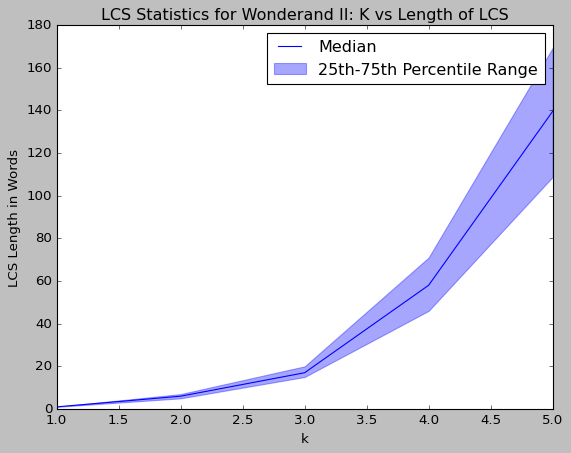

In [501]:
plot_lcs_statistics(book, "Wonderand II", stats)

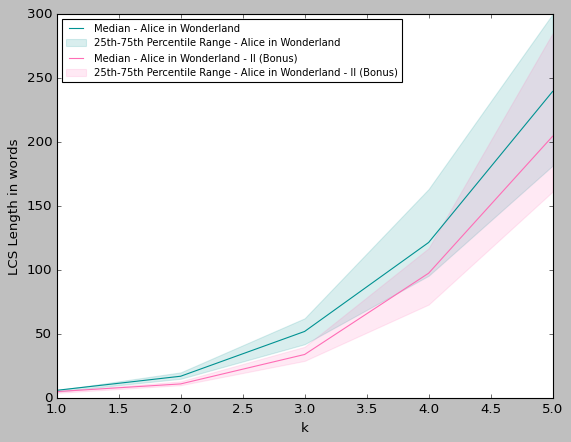

<Figure size 8000x8000 with 0 Axes>

In [502]:
plot_lcs_statistics_one_frame(
    [
        {
            "book_name": "Alice in Wonderland",
            "stats": wonderland_stats
        }, {
            "book_name": "Alice in Wonderland - II (Bonus)",
            "stats": monte_cristo_stats
        }
    ]
)

#### Conclusion:

We can conclude from the graph, thought it is still exponentially growing, it is below the graph plotted by the earlier method, hence we can conclude smoothing and adding temperature scaling can improve the n-gram model